In [1]:
# 1) Import Libraries
import tensorflow as tf                                 
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2  
from tensorflow.keras import layers, models, optimizers 
from tensorflow.keras.callbacks import EarlyStopping  
import matplotlib.pyplot as plt                          
import numpy as np                                       
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score  
import seaborn as sns                                     
import pandas as pd  

In [2]:
# 2) Data Preparation & Data Augmentation
IMG_SIZE = (224,224)     
BATCH = 35               

train_gen = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input,  
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_ds = train_gen.flow_from_directory(
    r"C:\\Users\\Ahamed\\Downloads\\archive\\Training",  
    target_size=IMG_SIZE,                         
    batch_size=BATCH,                             
    class_mode='categorical',              
    subset='training'                             
)

val_ds = train_gen.flow_from_directory(
    r"C:\\Users\\Ahamed\\Downloads\\archive\\Training", 
    target_size=IMG_SIZE,                          
    batch_size=BATCH,                               
    class_mode='categorical',                  
    subset='validation',                            
)

test_gen = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input
).flow_from_directory(
    r"C:\\Users\\Ahamed\\Downloads\\archive\\Testing",   
    target_size=IMG_SIZE,                         
    batch_size=BATCH,                             
    class_mode='categorical',                         
    shuffle=False        
)

labels = list(test_gen.class_indices.keys())  
num_classes = len(labels) 

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [3]:
# 3) Build Models
def build_custom_cnn(input_shape=(224,224,3), num_classes=num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_mobilenetv2(num_classes=num_classes):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))  
    base.trainable = False
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [4]:
# 4) Training & Evaluation function
def train_and_evaluate(model, name, optimizer, epochs=20):
    opt_name = type(optimizer).__name__                  
    print(f"\n=== Training {name} with {opt_name} ===")

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  

    early_stop = EarlyStopping(
        monitor='val_loss',      
        patience=3,                
        restore_best_weights=True  
    )

    train_steps = train_ds.samples // train_ds.batch_size   
    val_steps = val_ds.samples // val_ds.batch_size         

    history = model.fit(
        train_ds,
        steps_per_epoch=train_steps,       
        validation_data=val_ds,
        validation_steps=val_steps,       
        epochs=epochs,
        callbacks=[early_stop]            
    )

    preds = model.predict(test_gen)                  
    y_pred = np.argmax(preds, axis=1)           
    y_true = test_gen.classes                   

    acc = accuracy_score(y_true, y_pred)     
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)  
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)      
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)           

    print(f"\n=== Classification Report ({name}) ===")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)  
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix - {name}")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Acc")         
    plt.plot(history.history['val_accuracy'], label="Val Acc")       
    plt.legend(); plt.title(f"{name} Accuracy Curve")

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")            
    plt.plot(history.history['val_loss'], label="Val Loss")          
    plt.legend(); plt.title(f"{name} Loss Curve")
    plt.show()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }


=== Training Custom CNN with Adam ===


c:\Users\Ahamed\anaconda3\envs\ml_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Ahamed\anaconda3\envs\ml_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 90s 673ms/step - accuracy: 0.5284 - loss: 1.0877 - val_accuracy: 0.5625 - val_loss: 1.2413
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 56s 434ms/step - accuracy: 0.4286 - loss: 1.1704

c:\Users\Ahamed\anaconda3\envs\ml_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.4286 - loss: 1.1704 - val_accuracy: 0.5616 - val_loss: 1.2410
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 92s 705ms/step - accuracy: 0.5910 - loss: 0.9592 - val_accuracy: 0.5545 - val_loss: 1.1327
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.5143 - loss: 1.0031 - val_accuracy: 0.5420 - val_loss: 1.1371
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 745ms/step - accuracy: 0.6157 - loss: 0.9266 - val_accuracy: 0.2821 - val_loss: 1.2588
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.5714 - loss: 0.9944 - val_accuracy: 0.2839 - val_loss: 1.2553
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step

=== Classification Report (Custom CNN) ===
              precision    recall  f1-score   support

      glioma       0.72      0.46      0.56       300
  meningioma       0.47      0.14      0.22       306
     notumor       0.74      0.51      0.61       405
   pituitary       0.39      0.97      0.56       300

  

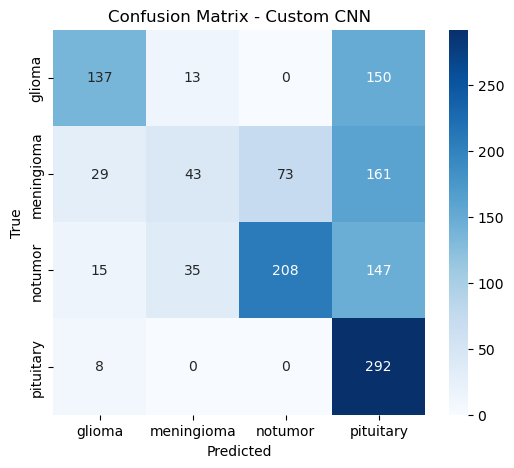

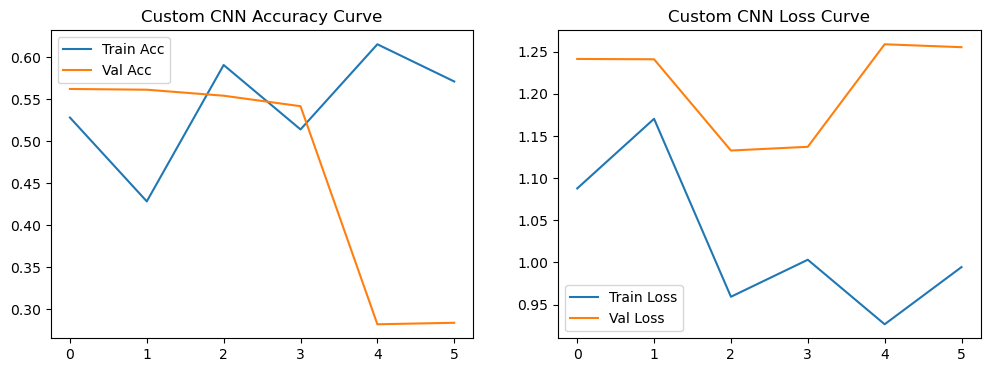

In [5]:
# 5) Run Experiments :
# Custom CNN
results = []

custom_cnn = build_custom_cnn()                          
results.append(train_and_evaluate(custom_cnn, "Custom CNN", optimizers.Adam(0.001)))



=== Training MobileNetV2 (Adam) with Adam ===
Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 88s 656ms/step - accuracy: 0.8097 - loss: 0.5736 - val_accuracy: 0.7696 - val_loss: 0.6055
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 37s 287ms/step - accuracy: 0.9143 - loss: 0.2390

c:\Users\Ahamed\anaconda3\envs\ml_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.9143 - loss: 0.2390 - val_accuracy: 0.7661 - val_loss: 0.6030
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 86s 658ms/step - accuracy: 0.8787 - loss: 0.3454 - val_accuracy: 0.8304 - val_loss: 0.4932
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.9143 - loss: 0.1660 - val_accuracy: 0.8143 - val_loss: 0.5007
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 81s 625ms/step - accuracy: 0.8959 - loss: 0.2952 - val_accuracy: 0.8223 - val_loss: 0.5151
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.8857 - loss: 0.2744 - val_accuracy: 0.8268 - val_loss: 0.4954
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step

=== Classification Report (MobileNetV2 (Adam)) ===
              precision    recall  f1-score   support

      glioma       0.88      0.76      0.82       300
  meningioma       0.71      0.64      0.67       306
     notumor       0.90      0.97      0.93       405
   pituitary       0.85      0.96      0.90  

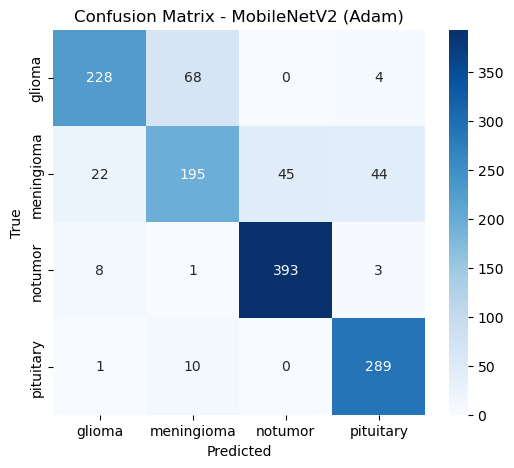

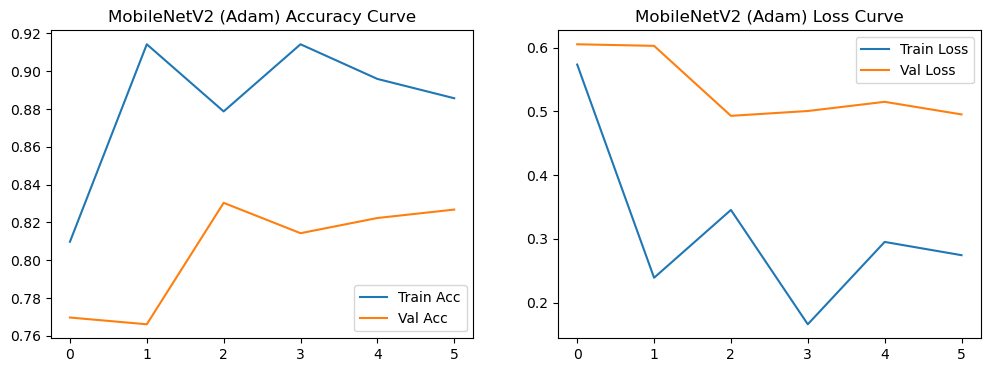

In [6]:
# MobileNetV2 with Adam Optimizer
mobilenet_adam = build_mobilenetv2()                     
results.append(train_and_evaluate(mobilenet_adam, "MobileNetV2 (Adam)", optimizers.Adam(0.001)))


=== Training MobileNetV2 (SGD) with SGD ===
Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 88s 655ms/step - accuracy: 0.8048 - loss: 0.5754 - val_accuracy: 0.7768 - val_loss: 0.6247
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.6190 - loss: 1.0701

c:\Users\Ahamed\anaconda3\envs\ml_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.6190 - loss: 1.0701 - val_accuracy: 0.7598 - val_loss: 0.6191
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 79s 609ms/step - accuracy: 0.8763 - loss: 0.3276 - val_accuracy: 0.7929 - val_loss: 0.5652
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.8857 - loss: 0.1994 - val_accuracy: 0.7937 - val_loss: 0.5608
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 85s 655ms/step - accuracy: 0.8893 - loss: 0.3039 - val_accuracy: 0.8134 - val_loss: 0.5003
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.8571 - loss: 0.3786 - val_accuracy: 0.8062 - val_loss: 0.5569
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 83s 642ms/step - accuracy: 0.8933 - loss: 0.2970 - val_accuracy: 0.8062 - val_loss: 0.5377
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.8571 - loss: 0.3164 - val_accuracy: 0.8223 - val_loss: 0.5001
Epoch 9/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 80s 616ms/step - accuracy: 0.9023 - loss: 0.2821 - val

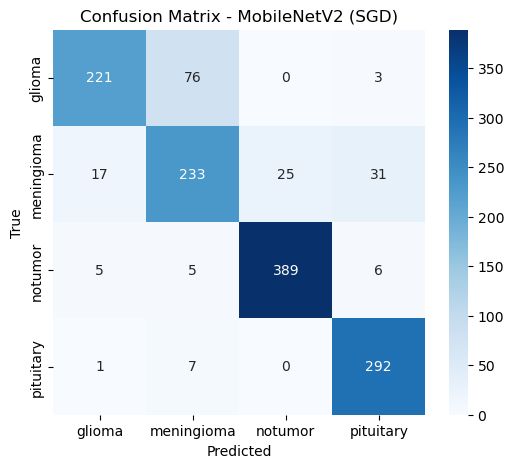

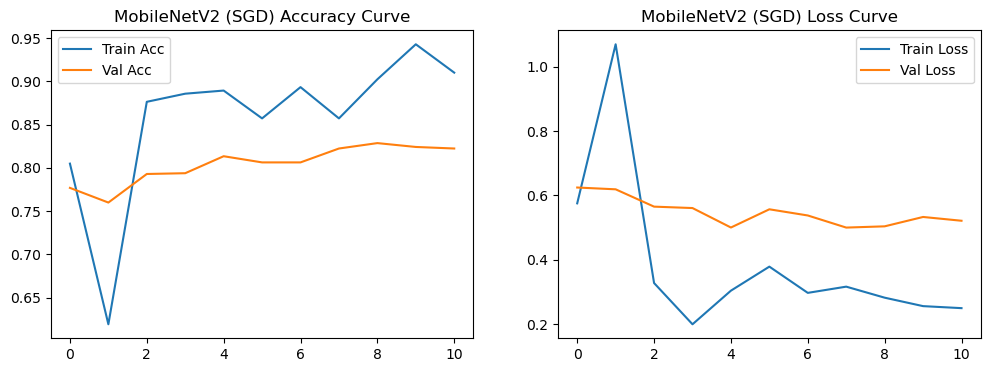

In [7]:
# MobileNetV2 with SGD Optimizer 
mobilenet_sgd = build_mobilenetv2()                      
results.append(train_and_evaluate(mobilenet_sgd, "MobileNetV2 (SGD)", optimizers.SGD(learning_rate=0.01, momentum=0.9)))

In [8]:
# 6) Comparison Table
df = pd.DataFrame(results)        
print("\n=== Comparison Table ===")
print(df)


=== Comparison Table ===
                Model  Accuracy  Precision    Recall  F1-score
0          Custom CNN  0.518688   0.593928  0.518688  0.493394
1  MobileNetV2 (Adam)  0.842868   0.839250  0.842868  0.838318
2   MobileNetV2 (SGD)  0.865751   0.868217  0.865751  0.864314
